<a href="https://colab.research.google.com/github/ankushbanyal/footwear_classification/blob/master/fynd_internship_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import numpy as np
import pandas as pd
!curl -s https://course.fast.ai/setup/colab | bash

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

In [0]:
#Code used to download the images
import urllib, csv, requests, os
from pathlib import Path

spreadsheetAddress = '/content/hook/xxx' 
targetDirectory = '/content/hook/' 

def getSpreadsheetContents(spreadsheetAddress):
    with open(spreadsheetAddress) as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        imageSet = {}
        for row in readCSV:
            if 'image_id' not in row:
                imageSet[row[0]] = row[1]
    return imageSet


if __name__ == "__main__":
    if os.path.exists(spreadsheetAddress) and os.path.exists(targetDirectory):
        imageDict = getSpreadsheetContents(spreadsheetAddress)
        for key, value in imageDict.items():
            if requests.get(value).status_code == 200:
                filename, file_extension = os.path.splitext(value)
                address = str(targetDirectory + key)
                urllib.request.urlretrieve(value, address)
    else:
        raise Exception("File not found")

In [0]:
path = Path('fynd/')

In [0]:
fynd_classes = ['backstrap', 'buckle', 'hook', 'lace', 'slip', 'zipper']

In [0]:
for c in fynd_classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

In [0]:
#Creating a data bunch
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.001,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

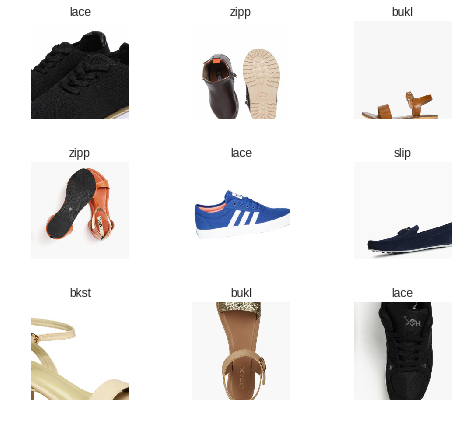

In [0]:
data.show_batch(rows=3, figsize=(7,6))

In [0]:
#Create a learner class using Resnet50
learn = cnn_learner(data, models.resnet50, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:06<00:00, 16128003.08it/s]


In [0]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.221091,0.439006,0.135514,02:51
1,0.275615,0.528049,0.158879,02:55
2,0.254046,0.437661,0.135514,02:56
3,0.205449,0.402405,0.121495,02:50
4,0.186569,0.436104,0.116822,02:51


In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1')

In [0]:
learn.unfreeze()

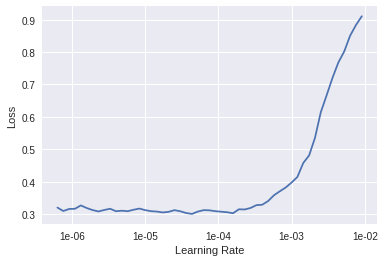

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(10, max_lr=slice(1e-6,5e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.335325,0.236854,0.925234,03:39
1,0.314949,0.232488,0.920561,03:34
2,0.297719,0.224114,0.934579,03:35
3,0.265514,0.222499,0.920561,03:35
4,0.247798,0.219124,0.920561,03:35
5,0.223806,0.217399,0.929907,03:35
6,0.208905,0.217240,0.920561,03:35
7,0.198574,0.217851,0.920561,03:35
8,0.182863,0.213317,0.920561,03:35
9,0.187971,0.210909,0.920561,03:36


In [0]:
learn.save('stage-2')

In [0]:
learn.load('stage-2')

In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


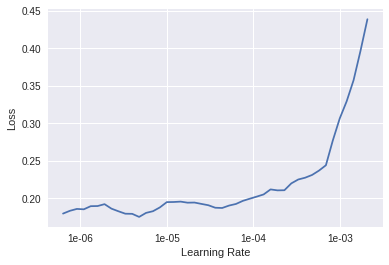

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.199557,0.111575,0.962617,03:35
1,0.195423,0.109832,0.967290,03:31
2,0.176725,0.112007,0.971963,03:31
3,0.175931,0.113775,0.962617,03:31


In [0]:
learn.load('stage-3')

Learner(data=ImageDataBunch;

Train: LabelList (10702 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
slip,slip,slip,slip,slip
Path: fynd;

Valid: LabelList (10 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
bukl,lace,slip,hook,bukl
Path: fynd;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 

In [0]:
interp = ClassificationInterpretation.from_learner(learn, ds_type=DatasetType.Train)

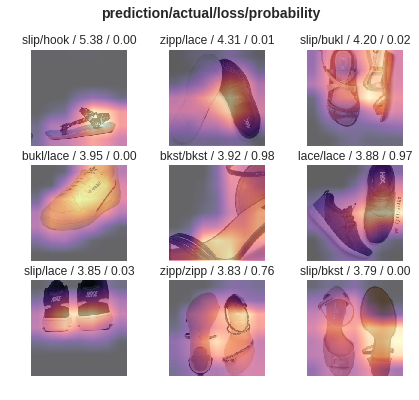

In [0]:
interp.plot_top_losses(9, figsize=(7,6))

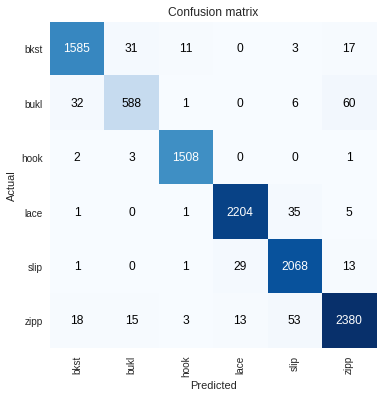

In [0]:
#Confusion matrix
interp.plot_confusion_matrix()

In [0]:
interp.most_confused(min_val=15)

In [0]:
learn.data.valid_ds.y.c2i

In [0]:
preds = learn.pred_batch()
type(preds), preds.shape, preds[:12]

In [0]:
##validation set predictions
log_preds, x = learn.TTA()

In [0]:
#convert tensor into probability
probs = np.exp(log_preds) / np.exp(log_preds).sum(1)[:,None]

In [0]:
#validation set details
probs, probs.shape

(tensor([[0.1824, 0.2032, 0.1439, 0.1491, 0.1797, 0.1417],
         [0.1427, 0.1329, 0.1327, 0.3214, 0.1367, 0.1336],
         [0.1352, 0.1371, 0.1346, 0.1475, 0.3026, 0.1430],
         [0.1314, 0.1314, 0.3378, 0.1342, 0.1332, 0.1320],
         [0.1364, 0.3191, 0.1329, 0.1329, 0.1334, 0.1453],
         [0.1365, 0.1382, 0.2680, 0.1368, 0.1383, 0.1823],
         [0.1426, 0.1472, 0.1657, 0.1580, 0.1582, 0.2283],
         [0.1429, 0.1673, 0.1406, 0.1403, 0.1553, 0.2535],
         [0.1369, 0.1369, 0.1417, 0.2607, 0.1852, 0.1386],
         [0.1388, 0.1406, 0.1379, 0.1561, 0.2612, 0.1654]]),
 torch.Size([10, 6]))

In [0]:
preds = np.argmax(log_preds, axis=1)
preds, preds.shape

In [0]:
type(valid_preds), valid_preds.shape,  valid_ys.shape

In [0]:
valid_preds, valid_ys

In [0]:
#To get predictions on the entire training dataset
#.Fix will ensure the order of the output predictions remains same as input loader order
train_preds, train_ys = learn.TTA(ds_type=DatasetType.Fix)

In [0]:
type(train_preds), train_preds.shape,  train_ys.shape

(torch.Tensor, torch.Size([10702, 6]), torch.Size([10702]))

In [0]:
#converting tensor into probability
train_preds, train_ys

(tensor([[1.8591e-02, 2.7137e-02, 2.9097e-03, 1.1706e-01, 4.9150e-01, 3.4280e-01],
         [4.9138e-03, 2.4903e-02, 2.0808e-03, 8.1834e-03, 8.7048e-01, 8.9434e-02],
         [2.9171e-03, 2.6970e-02, 1.1175e-04, 7.4880e-03, 9.1969e-01, 4.2823e-02],
         ...,
         [1.7897e-01, 7.8649e-01, 7.6921e-05, 2.7255e-04, 2.3810e-05, 3.4166e-02],
         [5.3775e-02, 7.1959e-01, 1.4270e-02, 3.8345e-04, 1.9628e-01, 1.5704e-02],
         [7.8636e-02, 5.6611e-01, 1.1333e-02, 2.8241e-02, 1.2000e-01, 1.9568e-01]]),
 tensor([4, 4, 4,  ..., 1, 1, 1]))

In [0]:
#Convert tensor to probablity
trainprobs = np.exp(train_preds) / np.exp(train_preds).sum(1)[:,None]
trainprobs, type(trainprobs)

In [0]:
#converting trained images list to a csv file 

train_probs = trainprobs.tolist()
my_df = pd.DataFrame(train_probs)
my_df.to_csv('image_probab.csv')

In [0]:
#input loader details
learn.data.train_ds.x.items, learn.data.train_ds.y.items

In [0]:
learn.data.train_ds.x, learn.data.train_ds.y

(ImageList (10702 items)
 Image (3, 500, 375),Image (3, 500, 375),Image (3, 500, 375),Image (3, 500, 375),Image (3, 500, 366)
 Path: fynd, CategoryList (10702 items)
 slip,slip,slip,slip,slip
 Path: fynd)

In [0]:
#Parameters details
learn.export()

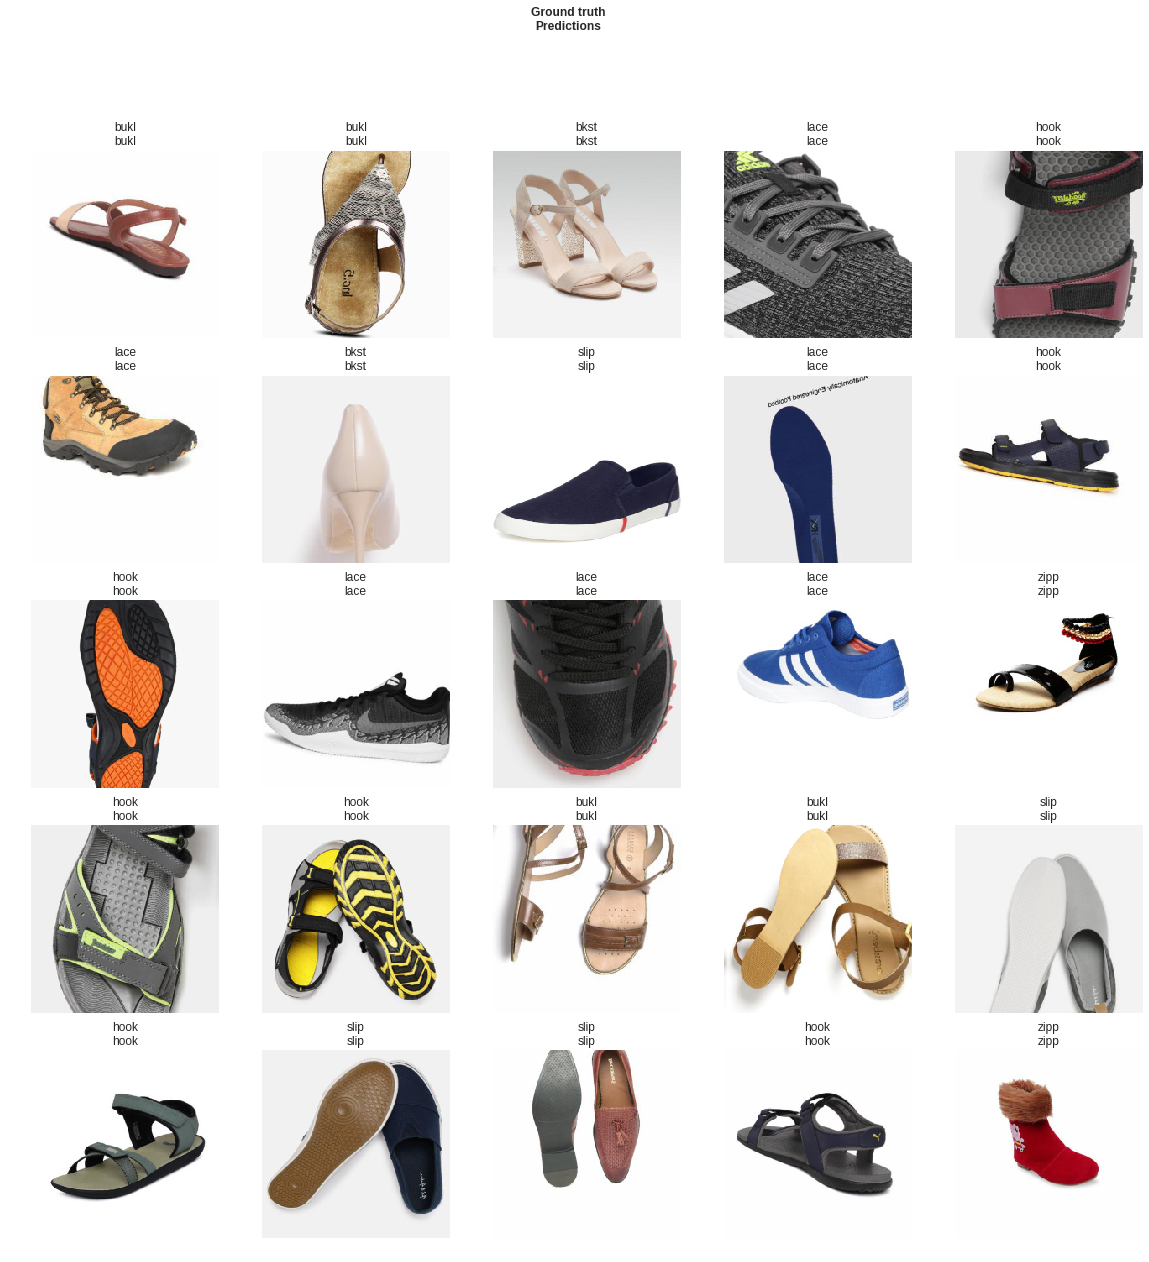

In [0]:
learn.show_results(ds_type=DatasetType.Train)

In [0]:
model_summary(learn, n=2) 

In [0]:
learn.model.eval()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

In [0]:
#input untrained file with images name and class
data.train_ds.to_csv('images.csv')

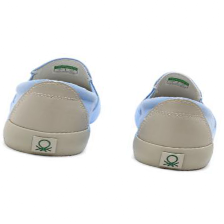

In [0]:
#random testing
img1 = data.train_ds[9644][0]
img1

In [0]:
learn.predict(img1)

(Category slip,
 tensor(4),
 tensor([0.0040, 0.0061, 0.0505, 0.0437, 0.8559, 0.0398]))